In [1]:
import os
from glob import glob

fig_dir = "figures/crossvalidation"
os.makedirs(fig_dir, exist_ok=True)

# set up the crossvalidation folders
crossvalidation_folders = glob(
    os.path.join(
        "..",
        "..",
        "scripts",
        "segmentation_training",
        "*fold*",
    )
)

# parse the crossvalidation folders into parameters
cv_details = [
    {
        "folder": sorted(glob(os.path.join(folder, "model*")))[-1],
        "model": folder.split("-")[0].split("/")[-1],
        **{
            k: float(v)
            for k, v in zip(
                ["first_layer_channels", "dropout_rate", "learning_rate", "fold"],
                folder.split("-")[2::2],
            )
        },
    }
    for folder in crossvalidation_folders
]

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator


# load the details of the cv results
for config in cv_details:
    # find the event file with the data stored
    event_file = glob(
        os.path.join(
            config["folder"],
            "log",
            "events.out*",
        )
    )[0]

    # load the data from the file
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()

    # store the results
    config["train_loss"] = [v.value for v in event_acc.Scalars("Loss/train")]
    config["val_loss"] = [v.value for v in event_acc.Scalars("Loss/validation")]
    for metric in ["auprc", "recall", "precision", "f1", "accuracy"]:
        config[metric] = [v.value for v in event_acc.Scalars(f"Metrics/{metric}")]

In [3]:
import pandas as pd
import numpy as np


# make dataframe
df_results = pd.DataFrame.from_dict(cv_details)

# take min/max over things
df_results["first_layer_channels"] = df_results["first_layer_channels"].apply(int)
df_results["folder"] = df_results["fold"].apply(int)
df_results["min_validation_loss"] = df_results["val_loss"].apply(min)
df_results["idx_min_validation_loss"] = df_results["val_loss"].apply(np.argmin)
df_results.head()

,folder,model,first_layer_channels,dropout_rate,learning_rate,fold,train_loss,val_loss,auprc,recall,precision,f1,accuracy,min_validation_loss,idx_min_validation_loss
0,1,unet_adversarial,8,0.15,0.0001,1.0,"[0.7151442170143127, 0.7083226442337036, 0.698...","[0.7001981139183044, 0.5898231863975525, 0.558...","[0.29669833183288574, 0.9268161654472351, 0.95...","[0.0003478068392723799, 0.6409587860107422, 0....","[0.9681797623634338, 0.9664833545684814, 0.955...","[0.0006953639094717801, 0.7707599401473999, 0....","[0.7486072182655334, 0.9041194915771484, 0.933...",0.117912,99
1,3,unet_adversarial,16,0.15,0.0100,3.0,"[0.5648785829544067, 0.2915268838405609, 0.190...","[0.17876552045345306, 0.12003958225250244, 0.1...","[0.9526388645172119, 0.9711591601371765, 0.976...","[0.9345450401306152, 0.8074829578399658, 0.829...","[0.8384174704551697, 0.9540024399757385, 0.957...","[0.8838752508163452, 0.8746490478515625, 0.888...","[0.9389287829399109, 0.9424387216567993, 0.948...",0.063540,13
2,0,unet_adversarial,32,0.05,0.0010,0.0,"[0.5344976186752319, 0.2979971766471863, 0.258...","[0.12220962345600128, 0.09377338737249374, 0.0...","[0.9732891321182251, 0.9818705320358276, 0.985...","[0.783592700958252, 0.8472605347633362, 0.8496...","[0.9667160511016846, 0.9676755666732788, 0.974...","[0.865574836730957, 0.9034734964370728, 0.9078...","[0.9396188855171204, 0.9550858736038208, 0.957...",0.059378,13
3,2,unet_adversarial,16,0.10,0.0100,2.0,"[0.5353105664253235, 0.2796492874622345, 0.188...","[3.8907439708709717, 0.13606713712215424, 0.09...","[0.6991234421730042, 0.9728087186813354, 0.980...","[0.9999586939811707, 0.8875094056129456, 0.922...","[0.26489946246147156, 0.9272407293319702, 0.92...","[0.4188430607318878, 0.9069401025772095, 0.925...","[0.30233034491539, 0.9542087912559509, 0.96238...",0.060559,15
4,3,unet_adversarial,16,0.10,0.0001,3.0,"[0.6528443098068237, 0.6337109208106995, 0.589...","[0.4607697129249573, 0.37502843141555786, 0.35...","[0.8753774166107178, 0.967361569404602, 0.9743...","[0.4852699637413025, 0.8202175498008728, 0.851...","[0.9695633053779602, 0.9616938233375549, 0.960...","[0.646809458732605, 0.8853393793106079, 0.9026...","[0.8681989312171936, 0.9471631646156311, 0.954...",0.072004,61


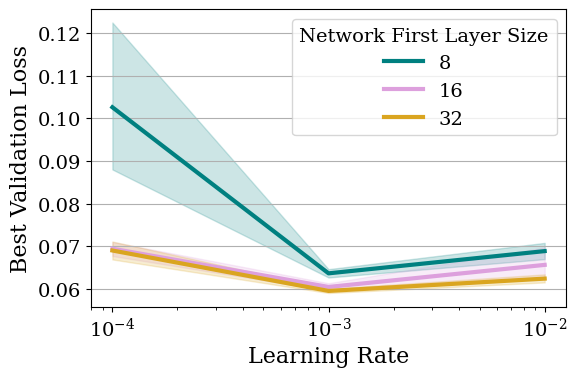

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# for font embeddings
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams["font.family"] = "serif"
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

palette = ["teal", "plum", "goldenrod"]

# Plot the results for a CV run
f, ax = plt.subplots(figsize=(6, 4))
ax.set(xscale="log")
sns.lineplot(
    data=df_results,
    x="learning_rate",
    y="min_validation_loss",
    hue="first_layer_channels",
    palette=palette,
    linewidth=3,
    ax=ax,
)
ax.set_xlabel("Learning Rate")
ax.set_ylabel("Best Validation Loss")
ax.legend(title="Network First Layer Size")
ax.grid(axis="y")
plt.tight_layout()
fig_file = os.path.join(fig_dir, "best_validation_loss.{}")
plt.savefig(fig_file.format("png"))
plt.savefig(fig_file.format("pdf"))
plt.show()